In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [3]:
def imshow(image=None, title="", size=10,  axis=False, cmap=None):
  w, h = image.shape[0], image.shape[1]
  aspect_ratio = w / h
  plt.figure(figsize=(size * aspect_ratio, size))
  plt.imshow(image, cmap=cmap)
  plt.title(title)
  plt.axis(axis)
  plt.show()

def imtorch(image, std=0.5, mean=0.5):
  image = image * std + mean
  batch = torchvision.utils.make_grid(image).numpy()
  plt.imshow(np.transpose(batch, (1, 2, 0)))
  plt.axis(False)
  plt.show()

def time_decorator(func):
  from time import time
  def wrapper(*arge, **kwarge):
    tic = time()
    result = func(*arge, **kwarge)
    toc = time()
    print(f"{func.__name__} took {toc - tic:.3f} seconds")
    return result
  return wrapper

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##**1.Trasnform**
'''torchvision.transforms'''

*   using the ```transforms.Compose``` function
*   use ```transforms.ToTensor()``` to convert the image data into a PyTorch Tensor
*   We use ```transforms.Normalize(mean, std, inplace=False)``` to normalize our pixel values

  1.   for gray channel image: input as ```(0.5, ), (0.5,)``` we Normalize our image data between -1 and +1
  2.   for RGB images: use ```transformed.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))``` instead

**Why Normalize?**

1. To ensure all features, or in our case, pixel intensities, are weighted equally when training our CNN
2. Makes training faster as it avoids oscilations during training
3. Removes and bias or skewness in our image data
4.For backward propagation activation functions derivative is nearly zero out of [-1, 1] bound 


**Normalization is done like this:**

`data = (data - mean) / std`

If mean = std = 0.5
- Min value = `(0 - 0.5)/0.5 = -1`
- Max value = `(1 - 0.5)/0.5 = 1`

**There are more important transformer for tensors or PIL images:**

https://pytorch.org/vision/stable/transforms.html

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

##**2.Load datasets**

some data sets contain image and coresponding label in each index

**train, dev, test  datasets**

- In some terminology there is a train/test sets but it's wrong test set is for evaluating model for 
- It's better to use train/dev/test sets for analyze the variance and bias error

https://pytorch.org/vision/stable/datasets.html

In [6]:
train_set = torchvision.datasets.MNIST('data/MNIST',
                                   train=True,
                                   download=True,
                                   transform=transform,
                                   target_transform=None)

dev_set = torchvision.datasets.MNIST('data/MNIST',
                                   train=False,
                                   download=True,
                                   transform=transform,
                                   target_transform=None)
print(len(train_set))
train_set.data.shape, dev_set.data.shape

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw

60000


(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
data_classes = train_set.classes
train_set.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

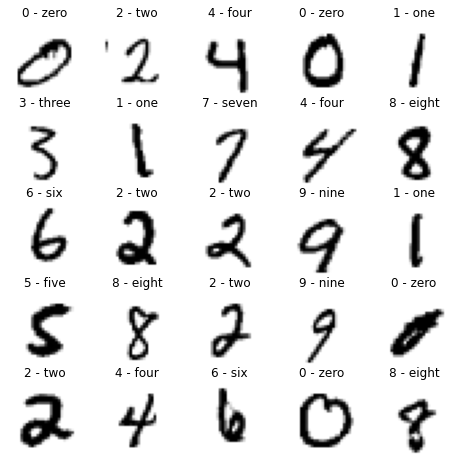

In [8]:
# torch.manual_seed(42)

data_classes = train_set.classes
fig = plt.figure(figsize=(8, 8))
rows, cols = 5, 5
for i in range(1, rows*cols + 1):
  idx = torch.randint(0, len(train_set), size=(1,)).item()
  img, label = train_set[idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray_r')
  plt.title(data_classes[label])
  plt.axis(False)

### **Create our Data Loader**
we can't feed all our data through the network at once, therefore that is why we split data into batches. 

For this purpose we use **Data Loader**

- We set **shuffle** equal to True to prevent data sequence bias.

- ```num_workers``` specifies how many CPU cores we wish to utilize, 0 means the main process will do the data loading.

https://pytorch.org/docs/stable/data.html

In [9]:
train_loader = torch.utils.data.DataLoader(train_set,
                                    batch_size=64,
                                    shuffle=True)

dev_loader = torch.utils.data.DataLoader(dev_set,
                                    batch_size=64,
                                    shuffle=False)

In [10]:
data_iter = iter(train_loader)

images, labels = next(data_iter)

# conver torch tensor to numpy with .numpy()
# convert numpy array to torch tensor: torch.from_numpy()
images.numpy().shape, labels.shape

((64, 1, 28, 28), torch.Size([64]))

###**Data visualization**
***we can use ```torchvision.utils.make_grid()``` to visualize images***

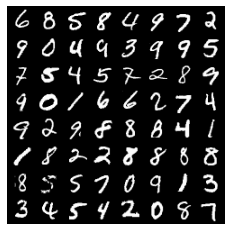

In [11]:
# We get the warning due to range of images elements: [-1, 1]
# So we revert normilize process to avoid warning
mean = std = 0.5

def imtorch(image):
  image = image * std + mean
  batch = torchvision.utils.make_grid(image).numpy()
  plt.imshow(np.transpose(batch, (1, 2, 0)))
  plt.axis(False)
  plt.show()

imtorch(images)

##**3.Building model**
![](https://vitalflux.com/wp-content/uploads/2021/11/VGG16-CNN-Architecture.png)

In [12]:
class NetMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    # input --> (64, 1, 28, 28)
    self.conv1 = nn.Conv2d(1, 32, 3)
    # input --> (64, 32, 26, 26)
    self.conv2 = nn.Conv2d(32, 64, 3)
    # input --> (64, 64, 24, 24)
    self.pool = nn.MaxPool2d(2)
    # input --> (64, 64, 12, 12)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(64*12*12, 128)
    self.fc2 = nn.Linear(128, 10)
  
  def forward(self, x: torch.tensor) -> torch.tensor:
    out = F.relu(self.conv1(x))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.flat(out)
    out = F.relu(self.fc1(out))
    return self.fc2(out)

model = NetMNIST().to(device)
print(model)

NetMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


###**Model layers**
we can simply print model or use torchsummary

In [13]:
from torchsummary import summary
summary(model, (1, 28, 28), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         MaxPool2d-3           [-1, 64, 12, 12]               0
           Flatten-4                 [-1, 9216]               0
            Linear-5                  [-1, 128]       1,179,776
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.59
Params size (MB): 4.58
Estimated Total Size (MB): 5.17
----------------------------------------------------------------


In [14]:
# model.state_dict()

###**Check if model works**

In [15]:
# Creat dummy data to check if out model works
x = torch.rand((64, 1, 28, 28)).to(device)
out = model(x)
out.shape

torch.Size([64, 10])

##**4.Optimizer and Loss function**
- optimizers: 

    https://pytorch.org/docs/stable/optim.html
- Loss function:

    https://pytorch.org/docs/stable/nn.html#loss-functions

In [16]:
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

def accuracy_fn(true, pred):
  correct = torch.eq(true, pred)
  return (torch.sum(correct)/len(true))*100

##**5.Training our model**

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

In [17]:
from time import time

start = time()
epochs = 5
epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
  print(f"\nEpoch: {epoch + 1}\n--------")
  train_loss = dev_loss = train_acc = dev_acc = 0

  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = criterion(y_pred, y)
    accuracy = accuracy_fn(y, y_pred.argmax(dim=1))

    train_loss += loss
    train_acc += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    if batch % 400 == 0 and batch != 0:
      print(f' batch: {batch} -- {batch*64} of {len(train_loader.dataset)} sample')

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  epoch_log.append(epoch)
  accuracy_log.append(train_acc)
  loss_log.append(train_loss)
  print(f'Train loss: {train_loss:.4f} -- Train accuracy: {train_acc:.4f}')

  model.eval()
  # with torch.inference_mode():
  with torch.no_grad():
    for X_dev, y_dev in dev_loader:
      X_dev, y_dev = X_dev.to(device), y_dev.to(device)
      y_pred_dev = model(X_dev)
      loss_dev = criterion(y_pred, y)
      accuracy_dev = accuracy_fn(y_dev, y_pred_dev.argmax(dim=1))

      dev_loss += loss_dev
      dev_acc += accuracy_dev

    dev_loss /= len(dev_loader)
    dev_acc /= len(dev_loader)
    print(f'Dev loss: {dev_loss:.4f} -- Dev accuracy: {dev_acc:.4f}\n')
    print(f'Time: {time() - start:.3f} seconds')



Epoch: 1
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.6355 -- Train accuracy: 82.2062
Dev loss: 0.1207 -- Dev accuracy: 93.3121

Time: 18.671 seconds

Epoch: 2
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.1950 -- Train accuracy: 94.2114
Dev loss: 0.2345 -- Dev accuracy: 96.1286

Time: 36.240 seconds

Epoch: 3
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.1201 -- Train accuracy: 96.4752
Dev loss: 0.0385 -- Dev accuracy: 97.4622

Time: 53.200 seconds

Epoch: 4
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.0885 -- Train accuracy: 97.4081
Dev loss: 0.0317 -- Dev accuracy: 97.8404

Time: 70.183 seconds

Epoch: 5
--------
 batch: 400 -- 25600 of 60000 sample
 batch: 800 -- 51200 of 60000 sample
Train loss: 0.0719 -- Train accuracy: 97.9194
Dev loss: 0.1325 -- Dev accuracy: 98.1588

Time: 

##**6.Saving our Model**
- ```torch.save()``` to save our model
- ```model.state_dict()``` save model weights in a dictionary format
- file format must be ```.pth``` or ```.pt```

In [18]:
# Save weights
PATH1 = "MNISTweights.pth"
torch.save(model.state_dict(), PATH1)

# Save the whole model
PATH2 = "MNIST_fisrtModelTorch.pt"
torch.save(model, PATH2)

##**7.Loading our Model**

In [ ]:
# Load previous weights on model
model2 = NetMNIST().to(device)
model2.load_state_dict(torch.load(PATH1))
model2.eval()

# Load entire model
model3 = torch.load(PATH2).to(device)
model3.eval()

print(f'Load weights:\n-------\n{model2}\n')
print(f'Load eintire model:\n-------\n{model3}')

Load weights:
-------
NetMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Load eintire model:
-------
NetMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


##**8.Getting prediction**

In [ ]:
testIter = iter(dev_loader)
images, labels = next(testIter)
images, labels = images.to(device), labels.to(device)

out = model2(images)

_, prediction = torch.max(out, 1)

In [ ]:
acc = accuracy_fn(labels, prediction).item()
print(f"prediction accuracy is {acc} %")
labels, prediction

prediction accuracy is 100.0 %


(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
         4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
         4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0'),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
         4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
         4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0'))

In [ ]:
with torch.no_grad():
  for X_dev, y_dev in dev_loader:
    X_dev, y_dev = X_dev.to(device), y_dev.to(device)
    y_pred_dev = model2(X_dev)
    loss_dev = criterion(y_pred, y)
    accuracy_dev = accuracy_fn(y_dev, y_pred_dev.argmax(dim=1))

    dev_loss += loss_dev
    dev_acc += accuracy_dev

  dev_loss /= len(dev_loader)
  dev_acc /= len(dev_loader)

dev_acc.item()

98.63381958007812

##**9.Plot trainig log**

In [ ]:
Loss = [x.cpu().detach().numpy() for x in loss_log]
Accuracy = [x.cpu().detach().numpy() for x in accuracy_log]

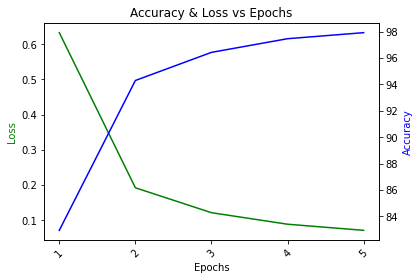

In [ ]:
fig, ax1 = plt.subplots()
plt.title("Accuracy & Loss vs Epochs")
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(range(1, epochs+1), Loss, 'g-')
ax2.plot(range(1, epochs+1), Accuracy, 'b-')

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color='g')
ax2.set_ylabel("Accuracy", color='b')
# plt.xlim(0, 5)
plt.xticks(range(1, 6))

plt.show()